# Precipitation Seasonal Climatology

* DJF and MAM for ERA5, IMERG-PM, and APHRODITE
* Total Seasonal Precip
* AR % contribution (seasonal)
* Standard Deviation

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Other
from scipy.ndimage import gaussian_filter
from pathlib import Path
from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap
from ar_funcs import get_ar_days, get_topo_mask, calc_seasonal_contribution, calc_seasonal_contribution_ar_mask
import nclcmaps as nclc

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


## Data

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'
ssn='djfmam'

# start date and end date
start_date = '2000-12-01 09:00'
start_date2 = '2000-12-01 00:00'
end_date = '2015-05-31 09:00'

# Select lat/lon grid
lonmin = 60
lonmax = 100
latmin = 20
latmax =  45

### AR Catalog

In [5]:
# if using single bound box with elevation mask
bound_box = [20, 40, 65, 97]
trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=False, bbox=bound_box, elev_thres=1000.)
# fix time from 09:00 each day to 00:00
df.index = df.index.strftime("%Y-%m-%d")
df

# # if using 3 subregions and threshold
# trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=True, bbox=None, thresh=0.05)
# df


,ar
time,
2000-12-01,1.0
2000-12-02,1.0
2000-12-03,0.0
2000-12-04,1.0
2000-12-05,0.0
...,...
2015-05-27,1.0
2015-05-28,0.0
2015-05-29,0.0


### APHRODITE

In [6]:
filename_pattern1 = path_to_data + 'APHRODITE/APHRO_MA_025deg_V1101.2*.nc'
f1 = xr.open_mfdataset(filename_pattern1, engine='netcdf4', concat_dim='time', combine='by_coords')
f1 = f1.rename({"longitude": "lon", "latitude": "lat"})
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

filename_pattern2 = path_to_data + 'APHRODITE/APHRO_MA_025deg_V1101_*.nc'
f2 = xr.open_mfdataset(filename_pattern2, engine='netcdf4', concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f2.nbytes / 1e9))

aphr = xr.merge([f1, f2])
aphr = aphr.sel(time=slice(start_date2, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
aphr = aphr.rename({'precip': 'prec'})
aphr

ds size in GB 2.36

ds size in GB 2.36



/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. 

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 160, time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-01 2000-12-02 ... 2015-05-31
  * lon      (lon) float64 60.12 60.38 60.62 60.88 ... 99.12 99.38 99.62 99.88
  * lat      (lat) float64 20.12 20.38 20.62 20.88 ... 44.12 44.38 44.62 44.88
Data variables:
    prec     (time, lat, lon) float32 dask.array<chunksize=(2953, 100, 160), meta=np.ndarray>
    rstn     (time, lat, lon) float32 dask.array<chunksize=(2953, 100, 160), meta=np.ndarray>

### IMERG-PM

In [7]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

filename_pattern1 = path_to_data + 'IMERGV06B/3B-DAY.MS.MRG.3IMERG.20*.nc4'
gpm = xr.open_mfdataset(filename_pattern1, engine='netcdf4', concat_dim='time', combine='by_coords',
                           preprocess=preprocess)

print('ds size in GB {:0.2f}\n'.format(gpm.nbytes / 1e9))
gpm = gpm.transpose('lat', 'lon', 'time')
gpm = gpm.sel(time=slice(start_date2, end_date))
gpm = gpm.rename({'precipitationCal': 'prec'})
gpm

ds size in GB 2.80



<xarray.Dataset>
Dimensions:  (lat: 250, lon: 400, time: 5295)
Coordinates:
  * lat      (lat) float32 20.05 20.149998 20.250004 ... 44.850002 44.95001
  * lon      (lon) float32 60.05 60.150005 60.249996 ... 99.85002 99.95
  * time     (time) object 2000-12-01 00:00:00 ... 2015-05-31 00:00:00
Data variables:
    prec     (lat, lon, time) float32 dask.array<chunksize=(250, 400, 1), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2019-11-18 19:55:33 GMT Hyrax-1.15.1 https://gpm1.gesdis...

### ERA5

In [8]:
### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

filepath_pattern = path_to_data + 'ERA5/prec/daily/out.era5*.nc'
era = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(era.nbytes / 1e9))
era = era.sel(time=slice(start_date, end_date))
# fix time from 09:00 each day to 00:00
era['time'] = era.indexes['time'].normalize()

# rename lat lon prec
rename_dict_era = {'mtpr': 'prec', 
                   'latitude': 'lat',
                   'longitude': 'lon'}

era = era.rename(rename_dict_era)
era = era.assign(prec=lambda era: era['prec']*86400) # convert to mm day-1
# subset to dates

era

ds size in GB 0.97



<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 101, lon: 161, time: 5295)
Coordinates:
  * lon        (lon) float32 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float32 45.0 44.75 44.5 44.25 ... 20.75 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2000-12-01 2000-12-02 ... 2015-05-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    prec       (time, lat, lon) float64 dask.array<chunksize=(31, 101, 161), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed May 27 13:22:14 2020: cdo daymean era5_hma_025dg_6hr_pr...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.0rc3 (http://mpimet.mpg....

### Calculate climatologies

In [9]:
ds_lst = [aphr, gpm, era]

# # calculate seasonal contribution using AR mask
# clim_lst, frac, std_lst = calc_seasonal_contribution_ar_mask(ds_list)

# calculate seasonal contribution using AR days df
clim_lst, frac, std_lst = calc_seasonal_contribution(ds_lst, df)

## Create figure

In [10]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+5,5)

# get topo mask for 1000 m line
regridlats = era.lat
regridlons = era.lon
regrid_topo = get_topo_mask(regridlats, regridlons)

# hack for tick labels
share_bottom = [False]*2+[True]*1+[False]*2+[True]*2
share_right = [False]*3 + [True]*3

### Climatology Plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


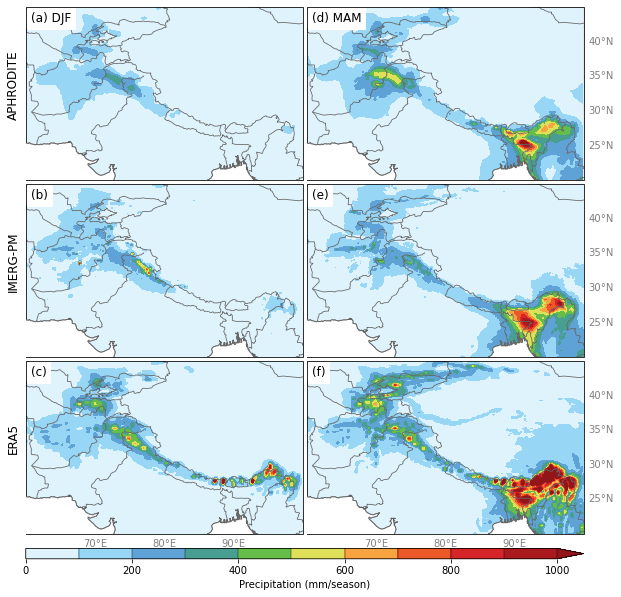

In [11]:
filepath = path_to_figs + 'prec_clim.png'
nrows = 3
ncols = 2

# Create figure
fig = plt.figure(figsize=(10, 15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.15, cbar_size='3%',label_mode='',
                direction='column')

###########################
########## PLOTS ##########
###########################
# cflevs = np.arange(0., 675., 50)
cflevs = np.arange(0., 1100., 100)
cmap = nclc.cmap('WhiteBlueGreenYellowRed')
# set plot labels
col_labels = ['(a) DJF', '(b)', '(c)', '(d) MAM', '(e)', '(f)']
row_labels = ['APHRODITE', 'IMERG-PM', 'ERA5', '', '', '']
ssn_lst = ['DJF']*3 + ['MAM']*3
sig = [2., 5., 3.]*2
cli_lst = [0, 1, 2]*2


for k, (ax, ssn, cli) in enumerate(zip(axgr, ssn_lst, cli_lst)):
    # select data
    cfdata = clim_lst[cli].prec.sel(season=ssn).values
    lats = clim_lst[cli].lat.values
    lons = clim_lst[cli].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k], mask_ocean=True)
    # Contour Filled
    # Average Seasonal Total
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
#     # Contour Lines
#     # Percent Contribution
#     cldata = frac[cli].prec.sel(season=ssn).values
#     contr = gaussian_filter(cldata, sigma=sig[k])
#     clevs = np.arange(20,105,20)
#     cs = ax.contour(lons, lats, contr, transform=datacrs,
#                     levels=clevs, colors='k', linewidths=1.1)
#     kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%i',
#                   'rightside_up': True, 'use_clabeltext': True}
#     plt.clabel(cs, **kw_clabels)
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
#                     linestyles='solid', transform=datacrs)
    
    # Subtitles
    # Column Labels
#     ax.set_title(col_labels[k], loc='left', fontsize=13)
    ax.annotate(col_labels[k], (5, 158), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')
    # Row labels
    ax.text(-0.02, 0.55, row_labels[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)

# Colorbar (single edge)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Precipitation (mm/season)')
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


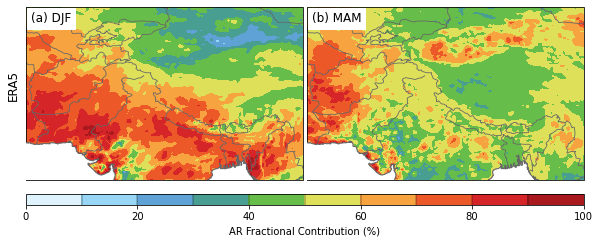

In [13]:
filepath = path_to_figs + 'prec_clim_frac_ERA5_only.png'
nrows = 1
ncols = 2

# Create figure
fig = plt.figure(figsize=(10, 5))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.15, cbar_size='3%',label_mode='',
                direction='column')

###########################
########## PLOTS ##########
###########################
# cflevs = np.arange(0., 675., 50)
cflevs = np.arange(100., 1100., 100)
# set plot labels
col_labels = ['(a) DJF', '(b) MAM']
row_labels = ['ERA5', '']
ssn_lst = ['DJF'] + ['MAM']
sig = [3., 3.]
cli_lst = [2, 2]

for k, (ax, ssn, cli) in enumerate(zip(axgr, ssn_lst, cli_lst)):
    # select data
    cfdata = frac[cli].prec.sel(season=ssn).values
    lats = clim_lst[cli].lat.values
    lons = clim_lst[cli].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k], mask_ocean=True)
    
    # Contour Filled
    # Average Seasonal Total
    cflevs = np.arange(0,105,10)
#     cmap= cmo.phase
#     clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='max', N=None)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='neither')
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
#                     linestyles='solid', transform=datacrs)
    
    # Subtitles
    # Column Labels
#     ax.set_title(col_labels[k], loc='left', fontsize=13)
    ax.annotate(col_labels[k], (5, 158), xycoords='axes points', fontsize=12.,
                backgroundcolor='white')
    # Row labels
    ax.text(-0.02, 0.55, row_labels[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)

# Colorbar (single edge)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('AR Fractional Contribution (%)')
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [ ]:
filepath = path_to_figs + 'prec_clim_frac.png'
nrows = 3
ncols = 2

# Create figure
fig = plt.figure(figsize=(10, 15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.15, cbar_size='3%',label_mode='',
                direction='column')

###########################
########## PLOTS ##########
###########################
# cflevs = np.arange(0., 675., 50)
cflevs = np.arange(100., 1100., 100)
# set plot labels
col_labels = ['(a) DJF', '(b)', '(c)', '(d) MAM', '(e)', '(f)']
row_labels = ['APHRODITE', 'IMERG-PM', 'ERA5', '', '', '']
ssn_lst = ['DJF']*3 + ['MAM']*3
sig = [2., 5., 3.]*2
cli_lst = [0, 1, 2]*2

for k, (ax, ssn, cli) in enumerate(zip(axgr, ssn_lst, cli_lst)):
    # select data
    cfdata = frac[cli].prec.sel(season=ssn).values
    lats = clim_lst[cli].lat.values
    lons = clim_lst[cli].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k], mask_ocean=True)
    
    # Contour Filled
    # Average Seasonal Total
    cflevs = np.arange(0,105,10)
#     cmap= cmo.phase
#     clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='max', N=None)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='neither')
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
#                     linestyles='solid', transform=datacrs)
    
    # Subtitles
    # Column Labels
#     ax.set_title(col_labels[k], loc='left', fontsize=13)
    ax.annotate(col_labels[k], (5, 158), xycoords='axes points', fontsize=12.,
                backgroundcolor='white')
    # Row labels
    ax.text(-0.02, 0.55, row_labels[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)

# Colorbar (single edge)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('AR Fractional Contribution (%)')
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


### Standard Deviation Plots

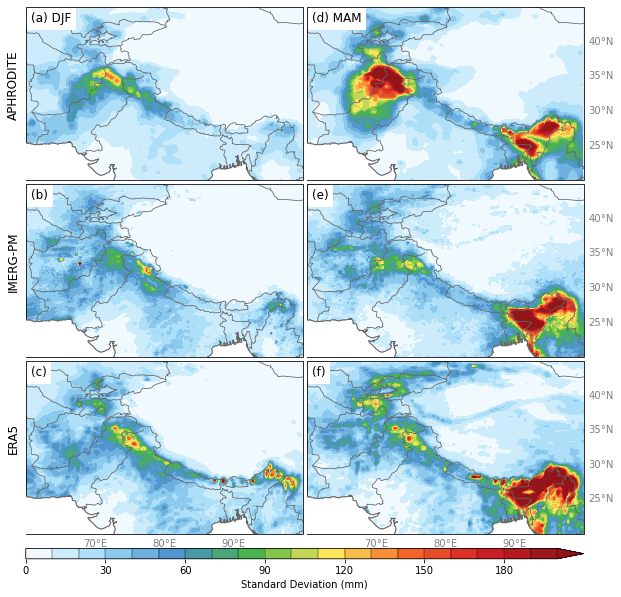

In [44]:
filepath = path_to_figs + 'prec_std.png'
nrows = 3
ncols = 2

# Create figure
fig = plt.figure(figsize=(10,15))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.15, cbar_size='3%',label_mode='',
                direction='column')

###########################
########## PLOTS ##########
###########################
# set plot labels
col_labels = ['(a) DJF', '(b)', '(c)', '(d) MAM', '(e)', '(f)']
row_labels = ['APHRODITE', 'IMERG-PM', 'ERA5', '', '', '']
ssn_lst = ['DJF']*3 + ['MAM']*3
cli_lst = [0, 1, 2]*2

for k, (ax, ssn, cli) in enumerate(zip(axgr, ssn_lst, cli_lst)):
    # select data
    cfdata = std_lst[cli].prec.sel(season=ssn).values
    lats = std_lst[cli].lat.values
    lons = std_lst[cli].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k], mask_ocean=True)
    # Contour Filled
    # Average Seasonal Total
    cflevs = np.arange(0, 210, 10)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
#                     linestyles='solid', transform=datacrs)
    
    # Subtitles
    # Column Labels
#     ax.set_title(col_labels[k], loc='left', fontsize=13)
    ax.annotate(col_labels[k], (5, 158), xycoords='axes points', fontsize=12.,
                backgroundcolor='white')
    # Row labels
    ax.text(-0.02, 0.55, row_labels[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=ax.transAxes)

# Colorbar (single edge)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Standard Deviation (mm)')
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
